In [1]:
import numpy as np
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import time

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [3]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

C:\Users\trekc\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
#фильтруем фичи (дата) по значению классификационных лэйблов (таргет), берем или цифру 3 или цифру 7
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
#тоже самое для тестового набора
test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
#необходимы препроцессинг лейблов, видимо не все значения имею тип integer, а нам нужен именно этот тип функция лонг позволяет нам 
#        это сделать (self.long() is equivalent to self.to(torch.int64). See to())
train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [6]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1 - sigmoid(x))

In [9]:
### КОД СЮДА ###
# x.shape = (128, 784)
learning_rate = 0.01
epochs = 5
b_s = 128
n_feat = 784

losses = [] #на каждой итерации (и для всех эпох) будем сохранять сюда наш Лосс, чтобы видеть обучается ли НС

w1 = np.random.rand(n_feat, 300)*0.01
b1 = np.zeros(1)
w2 = np.random.rand(300, 1)*0.01
b2 = np.zeros(1)

losses = []

for n_epoch in range(epochs):
    
    print(f'Epoch: {n_epoch + 1}')
    
    for x, y in train_loader:
        if len(y) == 108:
            break
        if x.shape[0] == 108:
            continue

        x = x.view(x.shape[0], -1).numpy()
        y = np.expand_dims(y.numpy(), 1)
        
        ### КОД СЮДА ###
        
        # forward
        z1 = np.dot(x, w1) + b1
        a1 = sigmoid(z1)
        z2 = np.dot(a1, w2) + b2
        a2 = sigmoid(z2)
        
        # рассчет bce
        loss = (-np.sum(np.multiply(np.log(a2), y) + np.multiply((1 - y), np.log(1 - a2)))) / b_s
        losses.append(loss)

        # backward
        dloss_dpred = (1-y)/(1-a2)-y/a2
        dpred_dz2 = sigmoid_deriv(z2)
        da1_dz1 = sigmoid_deriv(z1)
           
        dloss_dw2 = (np.dot(a1.T, dloss_dpred * dpred_dz2)) / b_s
        
        dloss_db2 = (np.dot(np.ones(b_s).T, dloss_dpred * dpred_dz2)) / b_s

        v = (dloss_dpred*dpred_dz2) * (w2.T*da1_dz1)
        
        dloss_dw1 = (np.dot(x.T, v))
        
        dloss_db1 = np.dot(np.ones((b_s,)), v)

        

        # gradient descent
        w1 = w1 - learning_rate * dloss_dw1
        w2 = w2 - learning_rate * dloss_dw2

        b1 = b1 - learning_rate * dloss_db1
        b2 = b2 - learning_rate * dloss_db2   

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


Text(0, 0.5, 'Loss function')

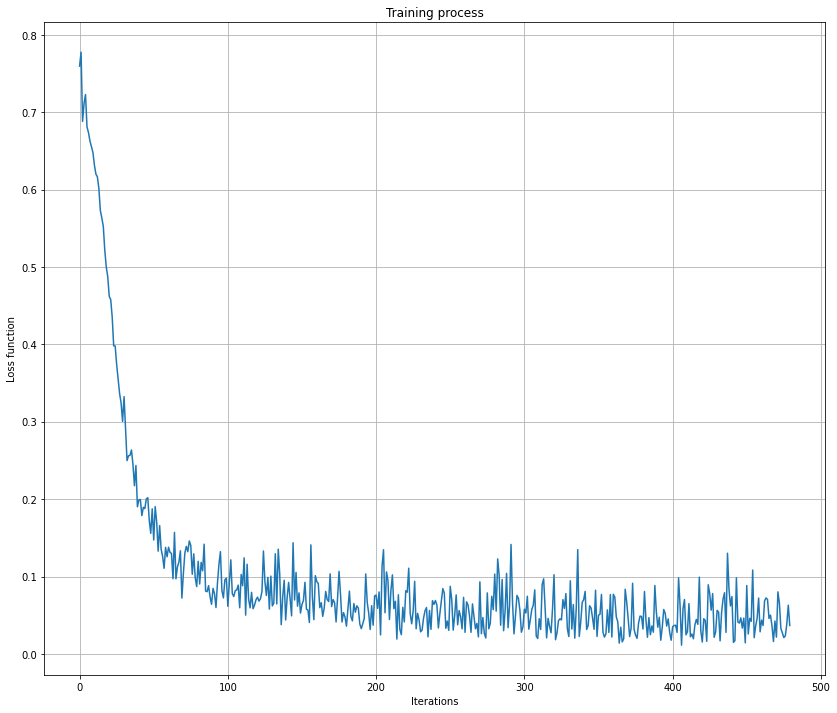

In [13]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')

## Подсказки по размерностям

### Forward

- z1 - первое линейное преобразование - (BATCH_SIZE, INNER_FEATURES)
- a1 - Применение нелинейности - (BATCH_SIZE, INNER_FEATURES)
- z2 - второе нелинейное преобразование - (BATCH_SIZE, 1)
- pred or A2- сигмоида - (BATCH_SIZE, 1)
- loss - функция потерь - скаляр

### Backward

- d_BCE/d_pred - градиент функции потерь по pred - (BATCH_SIZE, 1)
- d_pred/dz2 - градиент сигмоиды по z2 - (BATCH_SIZE, 1)
- dz2/da1 - градиент линейного преобразования по a1 - (BATCH_SIZE, INNER_FEATURES)
- dz2/dw2 - градиент линейного преобразования по w2 - (INNER_FEATURES, 1)
- dz2/db2 - градиент линейного преобразования по b2 - (1,)
- da1/dz1 - градиент нелинейной функции по z1 - (BATCH_SIZE, INNER_FEATURES)
- dz1/dw1 - градиент линейного преобразования по w1 - (IN_FEATURES, INNER_FEATURES)
- dz1/db1 - градиент линейного преобразования по b1 - (INNER_FEATURES,)

In [14]:
losses_test = []
predicted = []
true_lbls = []

for x, y in test_loader:
        if x.shape[0] != 128:
            continue
        x = x.view(x.shape[0], -1).numpy()
        y = np.expand_dims(y.numpy(), 1)
        
        ### КОД СЮДА ###
        
        # forward
        z1 = np.dot(x, w1) + b1
        a1 = sigmoid(z1)
        z2 = np.dot(a1, w2) + b2
        a2 = sigmoid(z2)
        
        # рассчет bce
        loss = (-np.sum(np.multiply(np.log(a2), y) + np.multiply((1 - y), np.log(1 - a2)))) / b_s
        losses.append(loss)


        losses_test.append(loss)
        predicted.extend(a2)
        true_lbls.extend(y) 

In [15]:
from sklearn.metrics import f1_score
pred = np.array([round(i[0]) for i in predicted]) 
# У нас были вероятности а нужны классы поэтому просто округлим каждое значени и получим лейблы 
t_lbls = np.array(true_lbls).squeeze() #снимем лишнюю размерность
f1 = f1_score(pred, t_lbls, average='weighted')
print('F1 score is equal to: {0:0.02f}'.format(f1))

F1 score is equal to: 0.98
